<a href="https://colab.research.google.com/github/PabloMendieta03/AprendizajeAutomatico-/blob/main/ClasificacionEnfermedadesOculares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLASIFICACIÓN DE ENFERMEDADES OCULARES
**CAPSTONE Grupo 1:** Carmen Gallardo, Marta Herraiz y Pablo Mendieta

## 1. Introdución

Este proyecto se centra en la aplicación de técnicas de aprendizaje automático para el diagnóstico de enfermedades oculares, utilizando un conjunto diverso de imágenes médicas. Se va a usar una base de datos que contiene 4 categorías, las primeras 3 categorías son de enfermedades que se pueden sufrir en los ojos: cataratas, glaucoma o retinopatía diabética. La cuarta categoría es 'normal'.

La capacidad de identificar con precisión condiciones como cataratas, retinopatía diabética, glaucoma y casos normales es esencial para facilitar intervenciones médicas tempranas y mejorar los resultados para los pacientes.

En el caso del glaucoma, se trata de un grupo de enfermedades oculares, estas afectan al nervio óptico y pueden provocar ceguera. La importancia de detectarlas con tiempo reside en que la pérdida de visión se produce de forma gradual y hasta que no está muy avanzada puede no detectarse. La retinopatía diabética es una enfermedad que puede producir ceguera en personas que sufren diabetes. En cuanto a las cataratas, es una enferdad que se da sobre todo en gente mayor, y al igual que las anteriores, produce la pérdida de visión.
  
A lo largo de este trabajo, exploraremos la implementación de un modelo de clasificación de imágenes para contribuir a este esfuerzo, evaluando su desempeño mediante métricas clave y visualizando resultados a través de matrices de confusión. Este proyecto representa un paso hacia la integración efectiva de la inteligencia artificial en el ámbito médico, promoviendo diagnósticos más rápidos y precisos. Este proyecto se nutre de investigaciones previas sobre el diagnostico oftalmologico gracias al machine learning.

**Antecedentes relevantes** : https://oa.upm.es/68588/1/TFG_MARCOS_NUNEZ_GUERRERO.pdf

https://uvadoc.uva.es/bitstream/handle/10324/50053/TFM-G1502.pdf?sequence=1&isAllowed=y

https://red.uao.edu.co/bitstream/handle/10614/9568/T07237.pdf?sequence=1&isAllowed=y

En consecuencia, este proyecto tiene como objetivo principal la distinción entre imágenes que presentan alguna de las enfermedades oculares mencionadas y aquellas que representan un ojo sano. Este enfoque no solo podría facilitar una detección más temprana de posibles afecciones oftalmológicas, sino que también podría ofrecer un respaldo adicional a los especialistas para una toma de decisiones más informada y, por ende, mejorar la atención y el cuidado de la salud ocular.



### Bibliotecas importadas


Se han utilizaron diversas bibliotecas en este proyecto. La biblioteca "kaggle" se empleó para acceder a conjuntos de datos médicos y la biblioteca "google.colab" se utilizó para cargar archivos en el entorno de Google Colab.

Para el procesamiento de imágenes, se emplearon las funciones de carga y conversión de imágenes de la biblioteca "tensorflow.keras.preprocessing.image". Se utilizaron también funciones de manipulación de datos de las bibliotecas "numpy" y "os". La visualización de imágenes se llevó a cabo con la ayuda de "matplotlib.pyplot".

La biblioteca "keras" proporcionó utilidades para codificación one-hot y manipulación de modelos de redes neuronales. Además, se hizo uso de la biblioteca "imblearn" para técnicas de sobremuestreo.

El modelado y entrenamiento de la red neuronal convolucional se realizó con la ayuda de "tensorflow.keras". La validación cruzada se llevó a cabo con "sklearn.model_selection.KFold", y la evaluación del modelo se realizó mediante la biblioteca "sklearn.metrics" y la visualización de la matriz de confusión con "seaborn" y "matplotlib.pyplot".

In [ ]:
!pip install kaggle
from google.colab import files

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

import matplotlib.pyplot as plt

from keras import utils
from keras.utils import to_categorical

import pandas

from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
import seaborn as sns

## 2. Datos


El conjunto de datos que se va a utilizar, es sobre enfermedades oculares, como se ha comentado antes. 1038 imágenes son ojos que sufren cataratas, 1098 retinopatía diabética, 1007 glaucoma y 1074 son ojos sanos.

Las imagenes son una exploración oftalmologica del fondo de ojo (parte posterior del interior del ojo que comprende la retina y el nervio óptico). Analizando el fondo de ojo, los oftamólogos puede identificar diversas enfermedades. Pero en muchos casos, puede ser complicado distinguir estas enfermedades sin ningún tipo de información clínica previa. Pero hay patrones que se pueden seguir para distinguirlas. En el caso del glaucoma, hay un adelgazamiento del anillo del nervio óptico, por lo que, un anillo en proporción más grueso indica un estado más avanzado de glaucoma (https://fseneca.es/web/deep-learning-para-la-deteccion-precoz-del-glaucoma). En el caso de las cataratas, los pacientes presentan daños en el cristalino, se ve porque este estará opaco o nublado, es decir, más borrosa y con menos luz (disminuye la calidad de la imagen). En la retinopatía diabética se pueden observar hemorragias (manchas rojas) exudados (manchas blancas) y cambios en los vasos de la retina. (**Fuente:** Doctora Ana Martín Bravo, Hospital Universitario El Escorial)

El conjunto de datos proviene de Kaggle. Es una base de datos de uso abierto licenciado por Open Data Commons (ODbL). Para exportarla desde kaggle en este código es necesario descargarse la API de Kaggle en su página web y subirla a este Jupyter Notebook. Posteriormente se debe descomprimir la carpeta de la base de datos. Esta a su vez contiene 4 carpetas con las imagenes con cada enfermedad.


In [ ]:
# Subir archivo kaggle.json
uploaded = files.upload()

# Movemos el archivo a la ubicación correcta
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

# Descomprimimos la carpeta con los datos
!unzip eye-diseases-classification.zip

Una vez descomprimida la carpeta *dataset* y conociendo que tiene 4 carpetas dentro (las 4 categorias), vamos a introducir en un tensor todas las imagenes.  Cada imágen se va a normalizar y redimensionar.

**Tamaño de las imágenes**

El tamaño elegido es **128 x 128**, hemos llevado a cabo pruebas con diferentes tamaños de imágenes y es el que mejor ha funcionado teniendo en cuenta que trabajamos con una RAM limitada. Además, tieniendo en cuenta la explicación anterior sobre las diferentes patologías, concluimos que el tamaño 128x128 es suficiente para que se distinga el nervio óptico.

Por otro lado, se van a normalizar las imagenes para facilitar la convergencia y buscar una mayor estabilidad.

In [ ]:
data_dir = '/content/dataset'  # Ruta del directorio donde están las carpetas de clases
num_classes = 4

img_size = (128, 128)

# Función para cargar y preprocesar imágenes en tensores
def load_images_to_tensors(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)

    for class_name in class_names: #recorre todas las imagenes
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # Carga y redimensiona la imagen
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array /= 255.0  # Normaliza los valores de píxeles

            #Se agrega la imagen y la etiqueta a las listas
            images.append(img_array)
            labels.append(class_names.index(class_name))

    # Convertimos las listas a tensores numpy
    images_tensor = np.array(images)
    labels_tensor = np.array(labels)

    return images_tensor, labels_tensor

# Llamamos a la función para cargar las imagenes
all_images, all_labels = load_images_to_tensors(data_dir)

# Mostramos la forma de las imagenes
print("Shape of all_images:", all_images.shape)
print("Shape of all_labels:", all_labels.shape)

Shape of all_images: (4217, 128, 128, 3)
Shape of all_labels: (4217,)


Una vez que todas las imágenes han sido agregadas a un tensor, procedemos a dividirlas en conjuntos de entrenamiento y prueba. Es esencial destacar que el tensor "all_images" sigue un orden específico (primero las imágenes de cataratas, seguido de las de Retinopatía diabética, etc.). Por lo tanto, optamos por asignar aproximadamente un 20% del total de imágenes para el conjunto de prueba. Dado que cada categoría cuenta con un poco más de 1000 imágenes, seleccionamos las primeras 200 imágenes de cada categoría para constituir nuestro conjunto de prueba.

Para evitar sesgos en la distribución de datos o patrones no deseados, llevamos a cabo una mezcla aleatoria de estas imágenes previamente seleccionadas. Es importante destacar que la separación de datos de validación se realizará en una etapa posterior del proceso.

In [ ]:
test_size_per_category = 200

# Función para dividir y mezclar los datos
def split_and_shuffle_data(images, labels, test_size_per_category):
    # Obtenemos índices para cada categoría
    indices_cataract = np.where(labels == 0)[0]
    indices_diabetic_retinopathy = np.where(labels == 1)[0]
    indices_glaucoma = np.where(labels == 2)[0]
    indices_normal = np.where(labels == 3)[0]

    # Seleccionamos aleatoriamente las imágenes para el conjunto de prueba
    test_indices_cataract = np.random.choice(indices_cataract, test_size_per_category, replace=False)
    test_indices_diabetic_retinopathy = np.random.choice(indices_diabetic_retinopathy, test_size_per_category, replace=False)
    test_indices_glaucoma = np.random.choice(indices_glaucoma, test_size_per_category, replace=False)
    test_indices_normal = np.random.choice(indices_normal, test_size_per_category, replace=False)

    # Concatenamos los índices de prueba
    test_indices = np.concatenate([test_indices_cataract, test_indices_diabetic_retinopathy, test_indices_glaucoma, test_indices_normal])

    # Obtenemos índices de entrenamiento
    train_indices = np.setdiff1d(np.arange(len(images)), test_indices)

    # Mezclamos los datos de entrenamiento y prueba
    train_images, train_labels = images[train_indices], labels[train_indices]
    test_images, test_labels = images[test_indices], labels[test_indices]

    # Mezclamos las etiquetas de entrenamiento y prueba
    shuffled_train_indices = np.random.permutation(len(train_images))
    shuffled_test_indices = np.random.permutation(len(test_images))

    train_images, train_labels = train_images[shuffled_train_indices], train_labels[shuffled_train_indices]
    test_images, test_labels = test_images[shuffled_test_indices], test_labels[shuffled_test_indices]

    return train_images, test_images, train_labels, test_labels

#Llamamos a la función
train_images, test_images, train_labels, test_labels = split_and_shuffle_data(
    all_images, all_labels, test_size_per_category
)

#Volvemos a verificar las formas de los tensores después de la división
print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_images: (3417, 128, 128, 3)
Shape of train_labels: (3417,)
Shape of test_images: (800, 128, 128, 3)
Shape of test_labels: (800,)


Estamos tratando un problema multiclase, por lo que es importante utilizar las etiquetas como categóricas. Es decir, se tendrá un vector de tamaño 1x4 donde se guardará un 0 si no pertenece a esa clase y un 1 en caso contrario. Las 4 clases son las mencinonadas antes. Nos interesa tener estas etiquetas categóricas para usar como función de pérdida *categorical_crossentropy*. Con esta función se calcula la diferencia de las distribuciones de probabilidad entre el valor que devuelve y el esperado. Penaliza así las predicciones que están muy lejos del valor esperado y favorece a las que están cerca.

In [ ]:
print("Etiquetas originales: ")
print(train_labels)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print("=Etiquetas tras la función to_categorical:")
print(train_labels)

Etiquetas originales: 
[3 3 0 ... 3 0 0]
=Etiquetas tras la función to_categorical:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


### Equilibrio en los datos

Pasamos a estudiar el equilibrio de los datos:

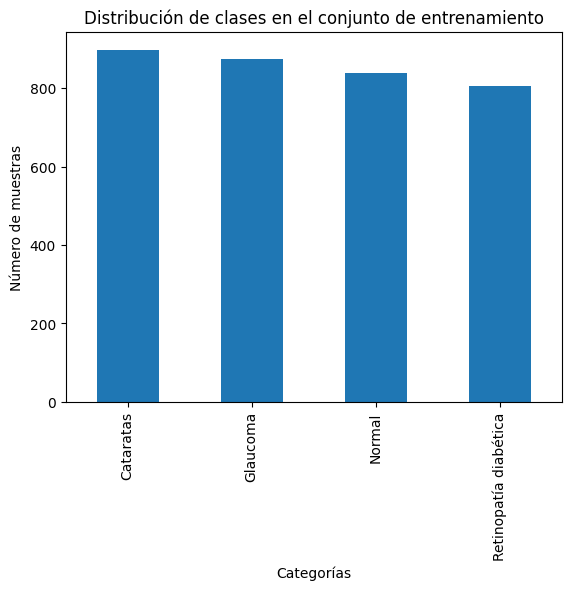

In [ ]:
# Obtenemos los índices de las clases (usando argmax para obtener el índice de la clase con el valor más alto)
class_indices = np.argmax(train_labels, axis=1)

# Creamos un DataFrame de la bilioteca pandas para facilitar el manejo de datos
df = pandas.DataFrame({'Categoría': class_indices})

#Nombramos los indices
class_mapping = {0: 'Cataratas', 1: 'Retinopatía diabética', 2: 'Glaucoma', 3: 'Normal'}
df['Categoría'] = df['Categoría'].map(class_mapping)

#Contamos la cantidad de muestras en cada categoría
class_counts = df['Categoría'].value_counts()

#Visualización
class_counts.plot(kind='bar')
plt.xlabel('Categorías')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.show()

 Observamos que los datos no están equiparados. Vamos a balancearlas aplicando una técnica denominada **sobremuestreo** (vamos a utilizar la biblioteca imblearn). El objetivo del balanceo de clases en el conjunto de entrenamiento es ayudar al modelo a aprender de manera más efectiva las características de la clase minoritaria, evitando que el modelo se sesgue hacia la clase mayoritaria debido a la gran cantidad de ejemplos de esa clase.

Además, en este caso las dos más bajas son la retinopatía diabética y la normal. En el caso de la normal esto puede suponer un problema, ya que el modelo podría sesgarse hacias las otras 3 clases, que se corresponden con las enfermedades. Esto puede generar un modelo que devuelve más falsos positivos de los deseados (en términos de enfermedades). Los remedios para estas enfermedades se deben aplicar antes de llegar a un estado de degeneración muy alto, por lo que aplicarlos pronto conviene. Si se aplican a un paciente sano puede resultar peligroso. Por ello, es muy importante evitar cualquier tipo de sesgo que tienda a devolver falsos positivos.


>**Destacar:** El balanceo de clases se aplica solo al conjunto de entrenamiento, y no al conjunto de prueba. La razón detrás de esto es que el conjunto de prueba debe ser un reflejo no manipulado del mundo real y, por lo tanto, debe mantener la distribución original de las clases.


In [ ]:
#Reshape para que RandomOverSampler funcione correctamente
train_images_reshaped = train_images.reshape(train_images.shape[0], -1)

#Inicializa el RandomOverSampler
ros = RandomOverSampler(random_state=42)

#Aplica el sobremuestreo
train_images_resampled, train_labels_resampled = ros.fit_resample(train_images_reshaped, train_labels)

#Reshape de nuevo a la forma original
train_images_resampled = train_images_resampled.reshape(train_images_resampled.shape[0], train_images.shape[1], train_images.shape[2], train_images.shape[3])

#Volvemos a verifica las formas después del sobremuestreo
print("Shape of train_images after resampling:", train_images_resampled.shape)
print("Shape of train_labels after resampling:", train_labels_resampled.shape)

Shape of train_images after resampling: (3592, 128, 128, 3)
Shape of train_labels after resampling: (3592, 4)


Una vez aplicado el sobre muestreo, volvemos a aplicar el código de antes para graficar el valanceo.

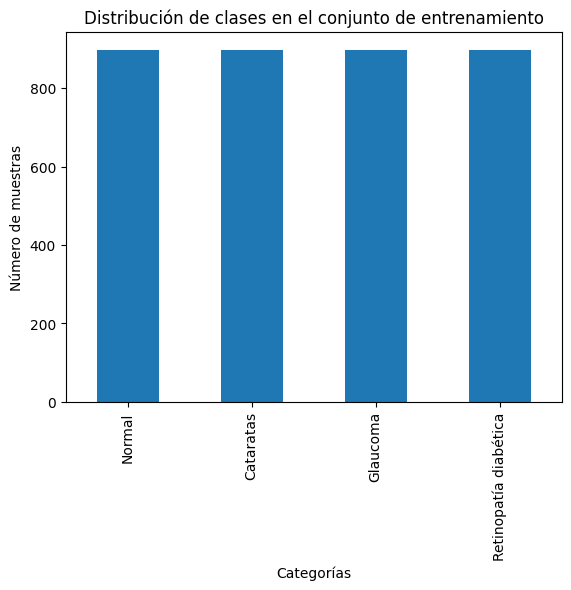

In [ ]:
#Obtenemos los índices de las clases (usando argmax para obtener el índice de la clase con el valor más alto)
class_indices = np.argmax(train_labels_resampled, axis=1)

#Creamos un DataFrame de pandas para facilitar el manejo de datos
df = pandas.DataFrame({'Categoría': class_indices})

#Nombramos los índices
class_mapping = {0: 'Cataratas', 1: 'Retinopatía diabética', 2: 'Glaucoma', 3: 'Normal'}
df['Categoría'] = df['Categoría'].map(class_mapping)

#Contamos la cantidad de muestras en cada categoría
class_counts = df['Categoría'].value_counts()

#Visualización
class_counts.plot(kind='bar')
plt.xlabel('Categorías')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.show()

>**Nota:** Hemos entrenado los datos con el modelo, que posteriormente explicaremos, sin balancear y balanceados. Pasamos de un **82%** a un **86%** de precisión.
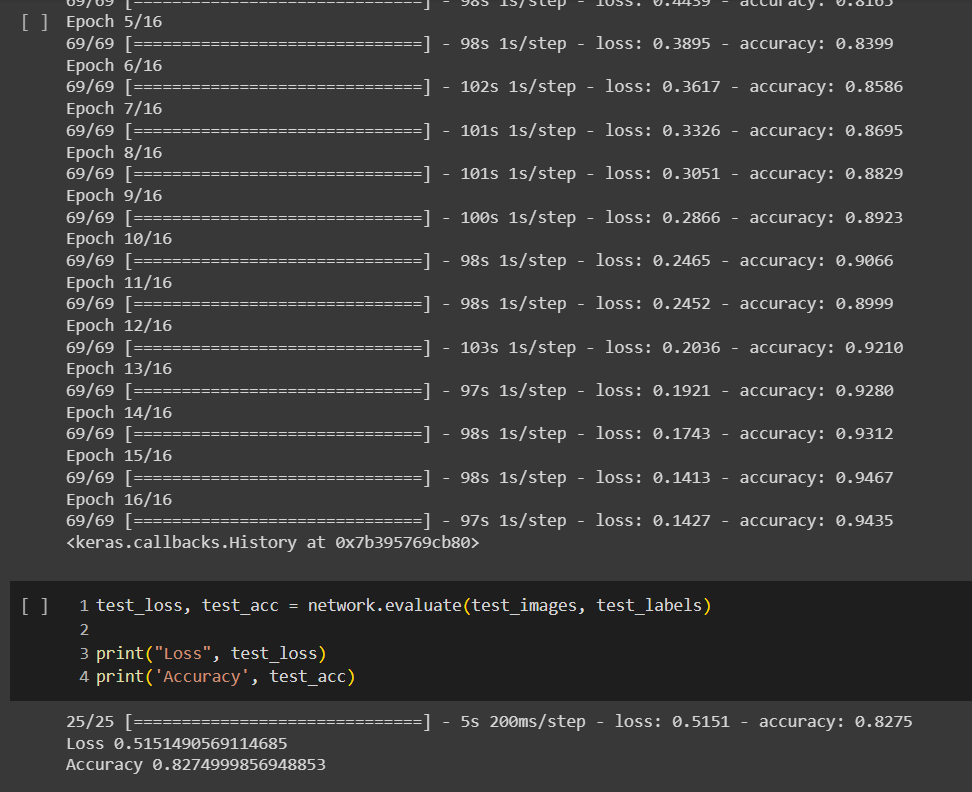


###Imagenes finales:

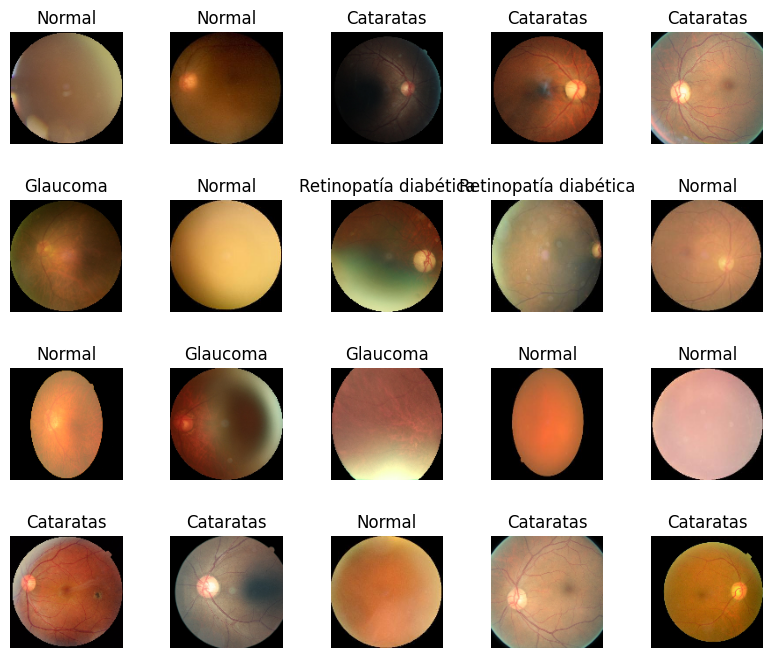

In [ ]:
#Imagenes que vamos a mostrar
num_images_to_show = 20

#Creamos subgráfica con las dimensiones deseadas
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

#Ajuste el espaciado
fig.subplots_adjust(hspace=0.5)

# Definir los índices
label_mapping = {0: 'Cataratas', 1: 'Retinopatía diabética', 2: 'Glaucoma', 3: 'Normal'}

# Convertir etiquetas categóricas a índices
label_indices = np.argmax(train_labels_resampled[:num_images_to_show], axis=1)

#Recorremos sobre las subgráficas y mostramos las imágenes con etiquetas
for i in range(num_images_to_show):
    #índice correspondiente
    label_index = label_indices[i]

    #nombre de la categoría
    label_name = label_mapping[label_index]

    #Obtenemos la imagen correspondiente
    image = train_images_resampled[i]

    #Configurar la subgráfica
    ax = axes[i // 5, i % 5]
    ax.imshow(image, cmap=plt.cm.binary)
    ax.set_title(label_name)
    ax.axis('off')

plt.show()

## 3. Métodos


Para este proyecto hemos usado varios métodos de aprendizaje automático para procesar las imágenes antes de entrenar el modelo y evaluarlo. Lo primero que se ha utilizado es una función para convertir los datos a tensores y normalizarlos. Para continuar, hemos mezclado las imágenes mediante *split_and_shuffle_data* para evitar sesgos y porque las imágenes al inicio estaban ordenadas por clase.

Por otro lado, era necesario pasar las etiquetas a categóricas, para resolver el problema multiclase. Por último, hemos utilizado el sobremuestreo para conseguir un equilibrio entre clases y evitar sesgos hacia las mayoritarias.

Al entrenar el modelo sin ajustar las imágenes mediante sobremuestreo (OVERSAMPLING), se observa que la precisión del modelo no cambia significativamente durante las épocas y la pérdida se mantiene constante o disminuye lentamente. Esto se debe al desequilibrio que presentaban las clases, donde la retinopatía diabética y la imagen del ojo sin enfermedad eran clases con menos imagenes que las demás. Con el sobremuestreo hemos solucionado este problema, consiguiendo que las clases minoritarias tuvieran la misma importancia que las otras a la hora de entrenar el modelo.

Vamos a utilizar redes convolucionales debido a que dan muy buen resultado en problemas de reconocimiento de imágenes. Estas utilizan filtros para detectar pequeños patrones de las imágenes y generar así una jerarquía. Es decir, detectan bordes, colores o texturas y generan con ello patrones.

Además, permiten utilizar capas *Pooling*, que reducen la dimensión espacial del mapa de características sin perder información. Esto hace que la red sea más eficiente e invariante a cambios en las posiciones de las características. Otro tipo de capa que vamos a usar es la densa, que se utiliza tras las capas de convolución y *Pooling* para aplanar el mapa de características.

Es importante comentar que son enfermedades degenerativas y por tanto, cuanto antes se detecten mejor. En el campo de la medicina las redes neuronales convolucionales podrían tener un gran alcance. En un **estudio sobre el glaucoma** realizado en la Universidad ICESI se obtuvieron resultados con precisiones entre el **90%** y el **99%**, se utilizaron varios modelos de redes neuronales convolucionales. Puede ser un gran avance para la medicina encontrar patrones, que no se habían estudiado previamente, que diagnostiquen correctamente enfermedades antes de tiempo.

*Documento de la Universidad comentada:*
https://repository.icesi.edu.co/biblioteca_digital/bitstream/10906/95207/1/T02445.pdf

La medida de éxito a utilizar es mínimo 25% ya que tenemos 4 categorías balanceadas. Con esto garantizamos que el modelo distinga todas las clases y no solo la mayoritaria (si la hubiera), aunque en nuestro caso hemos conseguido que sean todas iguales en cuanto a número de imágenes. Con esta medida aprenderá patrones de todas las clases.

Modelo de una red simple que consigue minimo el 25%:

Vamos a utilizar 3 capas, la de entrada tendrá un tamaño de 128x128x3. La siguiente capa será *flat* para convertir la entrada de 3 dimensiones en una de una dimensión, aplanarlo. La tercera será la capa de salida con función de activación *softmax*, ya que es un problema multiclase. Como optimizador usaremos *SGD* para evaluar por lotes y actualizar los pesos en dirección opuesta al gradiente.

In [ ]:
input_layer = Input(shape=(128, 128, 3))

flat = Flatten(input_shape=(128, 128, 3))(input_layer)
dense = Dense(128, activation='relu')(flat)

output_layer = Dense(4, activation='softmax')(dense)

network = Model(inputs=input_layer, outputs=output_layer)

network.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])


network.fit(train_images_resampled, train_labels_resampled, epochs=15, batch_size=256)

test_loss, test_acc = network.evaluate(test_images, test_labels)

print("Loss", test_loss)
print('Accuracy', test_acc)

Epoch 1/15
15/15 [==============================] - 1s 36ms/step - loss: 2.4797 - accuracy: 0.2731
Epoch 2/15
15/15 [==============================] - 1s 34ms/step - loss: 1.3002 - accuracy: 0.3577
Epoch 3/15
15/15 [==============================] - 1s 36ms/step - loss: 1.1756 - accuracy: 0.4763
Epoch 4/15
15/15 [==============================] - 1s 37ms/step - loss: 1.1378 - accuracy: 0.4992
Epoch 5/15
15/15 [==============================] - 1s 34ms/step - loss: 1.1115 - accuracy: 0.4994
Epoch 6/15
15/15 [==============================] - 1s 36ms/step - loss: 1.0806 - accuracy: 0.5167
Epoch 7/15
15/15 [==============================] - 1s 33ms/step - loss: 1.0853 - accuracy: 0.5329
Epoch 8/15
15/15 [==============================] - 1s 35ms/step - loss: 0.9967 - accuracy: 0.5576
Epoch 9/15
15/15 [==============================] - 1s 34ms/step - loss: 0.9305 - accuracy: 0.5947
Epoch 10/15
15/15 [==============================] - 1s 34ms/step - loss: 0.9311 - accuracy: 0.5899
Epoch 11/

**Modelo añadiendo convolucionales:**

Mantenemos la función de activación y la de pérdida, pero añadiendo una capa convolucional seguida de una de pooling. Con esto aumentamos el tamaño del filtro y conseguiremos una mayor precisión, ya que las capas convolucionales están especializadas en reconocimiento de imágenes.

https://www.kaggle.com/code/faizalkarim/pytorch-eye-disease-classification-93-7

In [ ]:
input_layer = Input(shape=(128, 128, 3))

conv = Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(128, 128, 3))(input_layer)
pol = MaxPooling2D(pool_size=(5, 5))(conv)

flat = Flatten()(pol)
dense = Dense(128, activation='relu')(flat)

output_layer = Dense(4, activation='softmax')(dense)

network = Model(inputs=input_layer, outputs=output_layer)

network.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])


network.fit(train_images_resampled, train_labels_resampled, epochs=15, batch_size=256)

test_loss, test_acc = network.evaluate(test_images, test_labels)

print("Loss", test_loss)
print('Accuracy', test_acc)

Epoch 1/15
15/15 [==============================] - 2s 62ms/step - loss: 1.3406 - accuracy: 0.4040
Epoch 2/15
15/15 [==============================] - 1s 61ms/step - loss: 1.2614 - accuracy: 0.4752
Epoch 3/15
15/15 [==============================] - 1s 60ms/step - loss: 1.2148 - accuracy: 0.4719
Epoch 4/15
15/15 [==============================] - 1s 59ms/step - loss: 1.1815 - accuracy: 0.4969
Epoch 5/15
15/15 [==============================] - 1s 60ms/step - loss: 1.1024 - accuracy: 0.5345
Epoch 6/15
15/15 [==============================] - 1s 60ms/step - loss: 1.0839 - accuracy: 0.5189
Epoch 7/15
15/15 [==============================] - 1s 59ms/step - loss: 1.0660 - accuracy: 0.5309
Epoch 8/15
15/15 [==============================] - 1s 60ms/step - loss: 1.0794 - accuracy: 0.5379
Epoch 9/15
15/15 [==============================] - 1s 60ms/step - loss: 1.0341 - accuracy: 0.5763
Epoch 10/15
15/15 [==============================] - 1s 59ms/step - loss: 1.0063 - accuracy: 0.5482
Epoch 11/

Si comparamos los dos modelos anteriores, comprobamos que, efectivamente, el uso de capas convolucionales aumenta la precisión del modelo, en este caso mas de un 10%.

**Modelo sobreentrenado:**

Vamos a generar un modelo sobreentrenado para averiguar dónde está la frontera entre el sobreajuste y el subajuste, con esto se consigue el modelo perfecto.

Para ello, vamos a utilizar una capa de entrada, seguida de 3 grupos de dos capas convolucionales con función de activación *ReLu*. Gracias a esta función eliminamos la linealidad del modelo. También usaremos padding para mantener el tamaño de entrada hasta la salida añadiendo 0 donde sea necesario.

Por último, usamos una capa flat para aplanar el mapa de características y una densa para guardar la clasificación final con función de activación *softmax*.

In [ ]:
input_layer = Input(shape=(128, 128, 3))

conv = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3))(input_layer)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv)
pol = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pol)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pol2 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pol2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
pol3 = MaxPooling2D(pool_size=(2, 2))(conv6)

flat = Flatten()(pol3)
dense = Dense(512, activation='relu')(flat)
output_layer = Dense(4, activation='softmax')(dense)

network = Model(inputs=input_layer, outputs=output_layer)

network.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


network.fit(train_images_resampled, train_labels_resampled, epochs=16, batch_size=20)

test_loss, test_acc = network.evaluate(test_images, test_labels)

print("Loss", test_loss)
print('Accuracy', test_acc)

Epoch 1/16
180/180 [==============================] - 13s 42ms/step - loss: 0.9448 - accuracy: 0.5501
Epoch 2/16
180/180 [==============================] - 5s 30ms/step - loss: 0.6242 - accuracy: 0.7274
Epoch 3/16
180/180 [==============================] - 6s 31ms/step - loss: 0.4706 - accuracy: 0.7976
Epoch 4/16
180/180 [==============================] - 5s 30ms/step - loss: 0.3963 - accuracy: 0.8335
Epoch 5/16
180/180 [==============================] - 5s 30ms/step - loss: 0.3405 - accuracy: 0.8600
Epoch 6/16
180/180 [==============================] - 5s 30ms/step - loss: 0.3177 - accuracy: 0.8658
Epoch 7/16
180/180 [==============================] - 5s 30ms/step - loss: 0.2581 - accuracy: 0.8981
Epoch 8/16
180/180 [==============================] - 5s 30ms/step - loss: 0.2091 - accuracy: 0.9184
Epoch 9/16
180/180 [==============================] - 5s 29ms/step - loss: 0.1873 - accuracy: 0.9282
Epoch 10/16
180/180 [==============================] - 5s 29ms/step - loss: 0.1511 - accur

### Modelo ajustado:



**HIPERPARÁMETROS SELECCIONADOS:**

*   **Batchsize:** usamos un batchsize de **60**, no es muy grande ya que no contamos con muchas imágenes. Así se actualizan los pesos con más frecuencia.

*   **Unidades de neuronas en capas convolucionales:** Usamos primero 32 neuronas, luego 64 y luego 128 para evitar cuellos de botella y permitir que el modelo detecte patrones más complejos. Por último la capa densa cuenta con 512 neuronas. Esto se corresponde con el número de filtros que se utilizan (características para aprender).

*   **Tamaño de la ventana del filtro:** en las capas convolucionales es de 3x3, es decir se va a ir desplazando el filtro 3 posiciones sobre la entrada en cada caso. En las capas Pooling se utiliza una dimensión más pequeña de 2x2. El uso de una ventana de 3x3 (considerada grande) es para disminuir los cálculos y la memoria. Como no contamos con muchas imágenes, usamos el tamaño grande. Para no crear falsos patrones con características finas, ya que no hay suficientes imágenes como para distinguir bien los pequeños detalles.

*   **Padding:** Se utiliza padding para rellenar con **0** la imagen y no perder la dimensión original. Con esto aseguramos que no pierde información de los bordes y que el mapa de características se reduzca más lentamente.

*   **Dropout:** Usamos un *Dropout* de **0.3** ( 30% ), esto se utiliza para poner a 0 algunas posiciones del mapa de características rompiendo así las casualidades que se hayan podido dar. Hay que destacar, que esta solo se debe usar durante el entrenamiento.

*   **Función de activación:** *ReLu*, para las capas convolucionales, funciona muy bien y añade no linealidades al modelo para aprender patrones más complejos.

*   **Softmax:** Para la capa de salida, ya que es para dar la solución a problemas multiclase.

*   **Función de pérdida:** *Categorical_crossentropy*, debido a que estamos en un problema multiclase.

*   **Optimizador:** *Adam*, combina momentum con *rmsprop*, y el optimizador *rmsprop* es el que mejor funciona generalmente.

In [ ]:
input_layer = Input(shape=(128, 128, 3))

conv = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3))(input_layer)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv)
pol = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.3)(pol)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pol)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pol2 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pol2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
pol3 = MaxPooling2D(pool_size=(2, 2))(conv6)

flat = Flatten()(pol3)
dense = Dense(512, activation='relu')(flat)
drop = Dropout(0.3)(dense)
output_layer = Dense(4, activation='softmax')(drop)

network = Model(inputs=input_layer, outputs=output_layer)

network.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


network.fit(train_images_resampled, train_labels_resampled, epochs=16, batch_size=60)


Epoch 1/16
60/60 [==============================] - 16s 148ms/step - loss: 1.0711 - accuracy: 0.4981
Epoch 2/16
60/60 [==============================] - 5s 76ms/step - loss: 0.7487 - accuracy: 0.6542
Epoch 3/16
60/60 [==============================] - 5s 78ms/step - loss: 0.5425 - accuracy: 0.7739
Epoch 4/16
60/60 [==============================] - 5s 76ms/step - loss: 0.4498 - accuracy: 0.8146
Epoch 5/16
60/60 [==============================] - 5s 77ms/step - loss: 0.3977 - accuracy: 0.8402
Epoch 6/16
60/60 [==============================] - 5s 78ms/step - loss: 0.3649 - accuracy: 0.8511
Epoch 7/16
60/60 [==============================] - 5s 76ms/step - loss: 0.3258 - accuracy: 0.8736
Epoch 8/16
60/60 [==============================] - 5s 77ms/step - loss: 0.2805 - accuracy: 0.8950
Epoch 9/16
60/60 [==============================] - 5s 76ms/step - loss: 0.2624 - accuracy: 0.8978
Epoch 10/16
60/60 [==============================] - 4s 75ms/step - loss: 0.2312 - accuracy: 0.9079
Epoch 1

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

print("Loss", test_loss)
print('Accuracy', test_acc)

25/25 [==============================] - 1s 16ms/step - loss: 0.4572 - accuracy: 0.8750
Loss 0.4571560323238373
Accuracy 0.875


Viendo que este modelo ya alcanza unos resultados bastante buenos, vamos a calcular el número de épocas aplicando el método de **k-iteraciones**.

Para ello usamos k = 4, por lo que en cada iteración se tomarán k - 1 grupos para el entrenamiento y el restante para el test. Una vez finaliza este proceso se halla la media y esta será la puntuación final.

Entrenando en el fold...
Epoch 1/30
45/45 [==============================] - 19s 212ms/step - loss: 1.1448 - accuracy: 0.4558 - val_loss: 0.9273 - val_accuracy: 0.5846
Epoch 2/30
45/45 [==============================] - 4s 89ms/step - loss: 0.7923 - accuracy: 0.6418 - val_loss: 0.6303 - val_accuracy: 0.7327
Epoch 3/30
45/45 [==============================] - 4s 82ms/step - loss: 0.5808 - accuracy: 0.7517 - val_loss: 0.4927 - val_accuracy: 0.8118
Epoch 4/30
45/45 [==============================] - 4s 79ms/step - loss: 0.4316 - accuracy: 0.8192 - val_loss: 0.5941 - val_accuracy: 0.7316
Epoch 5/30
45/45 [==============================] - 4s 82ms/step - loss: 0.4583 - accuracy: 0.8229 - val_loss: 0.4251 - val_accuracy: 0.8307
Epoch 6/30
45/45 [==============================] - 4s 82ms/step - loss: 0.3723 - accuracy: 0.8508 - val_loss: 0.4190 - val_accuracy: 0.8352
Epoch 7/30
45/45 [==============================] - 4s 81ms/step - loss: 0.3332 - accuracy: 0.8705 - val_loss: 0.3870 - val_acc

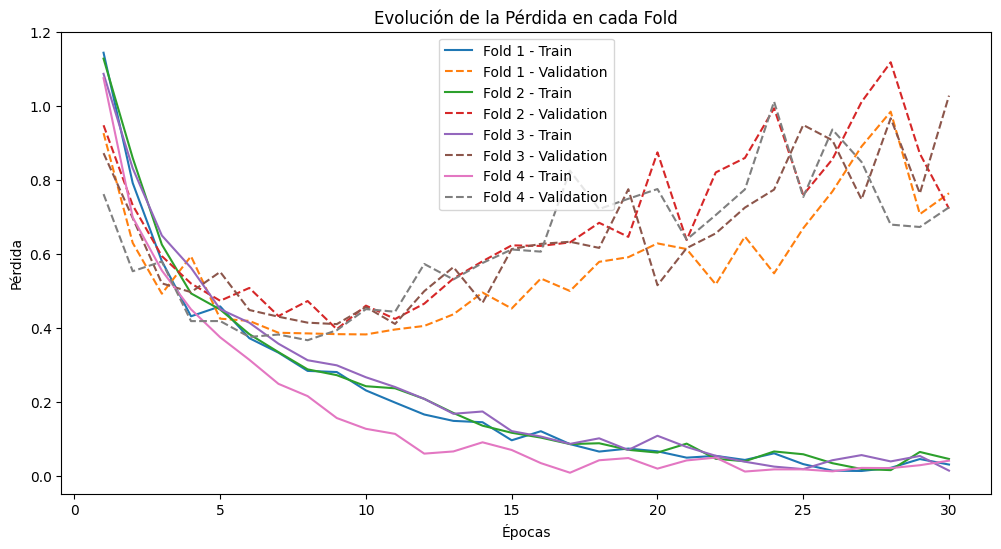

In [ ]:
def construir_modelo():
    input_layer = Input(shape=(128, 128, 3))
    conv = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3))(input_layer)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv)
    pol = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop = Dropout(0.3)(pol)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pol)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pol2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pol2)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    pol3 = MaxPooling2D(pool_size=(2, 2))(conv6)
    flat = Flatten()(pol3)
    dense = Dense(512, activation='relu')(flat)
    drop = Dropout(0.3)(dense)
    output_layer = Dense(4, activation='softmax')(drop)

    modelo = Model(inputs=input_layer, outputs=output_layer)
    modelo.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return modelo

k = 4
num_samples = len(train_images_resampled)
num_val_samples = num_samples // k
num_epochs = 30

#Inicializamos KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_train_histories = []
all_val_histories = []

for train_index, val_index in kf.split(train_images_resampled):
    print("Entrenando en el fold...")

    #Separación los datos en conjuntos de entrenamiento y validación como se ha explicado antes
    X_train, X_val = train_images_resampled[train_index], train_images_resampled[val_index]
    y_train, y_val = train_labels_resampled[train_index], train_labels_resampled[val_index]

    model = construir_modelo()

    #Iniciamos listas para almacenar los historiales de entrenamiento y validación de este fold
    train_history_fold = []
    val_history_fold = []

    #Entrenamiento
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=60, validation_data=(X_val, y_val), verbose=1)

    #Almacenamos los historiales de este fold en las listas generales
    train_history_fold = history.history['loss']
    val_history_fold = history.history['val_loss']

    all_train_histories.append(train_history_fold)
    all_val_histories.append(val_history_fold)

#Graficamos la evolución de la pérdida para cada fold
plt.figure(figsize=(12, 6))
for i, fold_history in enumerate(all_train_histories):
    plt.plot(range(1, num_epochs + 1), fold_history, label=f'Fold {i + 1} - Train')
    plt.plot(range(1, num_epochs + 1), all_val_histories[i], label=f'Fold {i + 1} - Validation', linestyle='dashed')

plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida en cada Fold')
plt.legend()
plt.show()

Viendo la gráfica, observamos que la pérdida aumenta a partir de la época **12**.

In [ ]:
input_layer = Input(shape=(128, 128, 3))

conv = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3))(input_layer)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv)
pol = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.3)(pol)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pol)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pol2 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pol2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
pol3 = MaxPooling2D(pool_size=(2, 2))(conv6)

flat = Flatten()(pol3)
dense = Dense(512, activation='relu')(flat)
drop = Dropout(0.3)(dense)
output_layer = Dense(4, activation='softmax')(drop)

network = Model(inputs=input_layer, outputs=output_layer)

network.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


network.fit(train_images_resampled, train_labels_resampled, epochs=12, batch_size=60)

Epoch 1/12
60/60 [==============================] - 7s 81ms/step - loss: 1.1067 - accuracy: 0.4811
Epoch 2/12
60/60 [==============================] - 5s 78ms/step - loss: 0.7146 - accuracy: 0.6743
Epoch 3/12
60/60 [==============================] - 5s 81ms/step - loss: 0.5457 - accuracy: 0.7706
Epoch 4/12
60/60 [==============================] - 5s 80ms/step - loss: 0.4361 - accuracy: 0.8263
Epoch 5/12
60/60 [==============================] - 5s 78ms/step - loss: 0.3741 - accuracy: 0.8511
Epoch 6/12
60/60 [==============================] - 5s 79ms/step - loss: 0.3304 - accuracy: 0.8675
Epoch 7/12
60/60 [==============================] - 5s 77ms/step - loss: 0.2795 - accuracy: 0.8842
Epoch 8/12
60/60 [==============================] - 5s 76ms/step - loss: 0.2554 - accuracy: 0.9001
Epoch 9/12
60/60 [==============================] - 5s 78ms/step - loss: 0.2115 - accuracy: 0.9173
Epoch 10/12
60/60 [==============================] - 5s 76ms/step - loss: 0.1767 - accuracy: 0.9329
Epoch 11/

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

print("Loss", test_loss)
print('Accuracy', test_acc)

25/25 [==============================] - 1s 15ms/step - loss: 0.4245 - accuracy: 0.8575
Loss 0.42452797293663025
Accuracy 0.8575000166893005


## 4. Hallazgos

Obervamos que alcanzamos una **accuracy final** del **85%**, pero esto no es suficiente para analizar los resultados. Vamos a hacer la matriz de confusión de las prediciones de las imagenes de test.

25/25 [==============================] - 0s 17ms/step


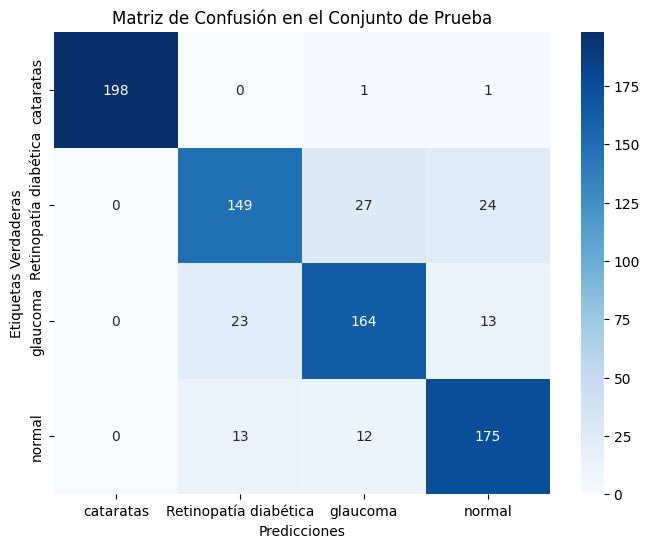

In [ ]:
#Clases de nuestro problema
class_names = ['cataratas', 'Retinopatía diabética', 'glaucoma', 'normal']

#Predicciones en el conjunto de prueba
test_predictions = network.predict(test_images)

# Conversión de las predicciones a clases
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Calcular la matriz de confusión (biblioteca sklearn)
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.show()

La sensibilidad y la especificidad son parámetros fundamentales en la evaluación de la eficacia de las pruebas diagnósticas en el ámbito médico, proporcionando una visión detallada de su rendimiento.

La sensibilidad de una prueba refleja su capacidad para detectar a todas las personas que realmente tienen la enfermedad. En el caso de las "cataratas", este indicador es extraordinariamente alto, alcanzando el 99%. Este resultado significa que la prueba presenta una eficacia excepcional al identificar a prácticamente todos los individuos afectados, minimizando los falsos negativos a solo dos casos de los 200 evaluados.

Por otro lado, la especificidad evalúa la habilidad de la prueba para etiquetar correctamente a las personas sanas. En el escenario de las "cataratas", la especificidad se sitúa en el 100%, lo que indica que todos los pacientes sanos fueron correctamente identificados como tales. Esta tasa perfecta de especificidad resalta la capacidad de la prueba para evitar errores de falsos positivos en esta categoría específica.

En el contexto de la retinopatía diabética, la sensibilidad se ubica en el 74.5%, sugiriendo una capacidad sólida para detectar la enfermedad. Mientras tanto, la especificidad del 94% indica que la prueba tiene un rendimiento robusto al identificar a los individuos sin la condición. Este equilibrio entre sensibilidad y especificidad sugiere una utilidad eficaz en la identificación y confirmación de la retinopatía diabética.

Para el caso del glaucoma, la sensibilidad alcanza el 82%, señalando una efectividad considerable en la detección de la enfermedad. La especificidad del 93% destaca la capacidad de la prueba para minimizar los falsos positivos, proporcionando así una evaluación precisa y fiable.

Es crucial destacar que, en este caso, ningún paciente tiene múltiples enfermedades, simplificando la interpretación de los resultados y permitiendo un enfoque más claro en la evaluación de cada patología por separado.

En términos prácticos, si se utiliza la prueba como un medio de cribado, donde se busca identificar a todos los individuos con la enfermedad, la sensibilidad se vuelve crucial. Sin embargo, si se emplea como una confirmación después de que un médico sospecha que el paciente podría tener la enfermedad, la especificidad cobra mayor relevancia.

Dado que el modelo proporciona una mayor especificidad, se podría concluir que es una herramienta eficaz para la confirmación. Es esencial subrayar que estas herramientas deben ser utilizadas bajo la supervisión de un médico y no deben reemplazar el juicio clínico.


**Bibliografía:** https://docs.bvsalud.org/biblioref/2018/05/883697/importancia-calculo-sensibilidad-y-especifidad.pdf
https://www.sergas.es/Saude-publica/Documents/1932/6-Ayuda%20Pruebas%20diagnsticas.pdf

>**Nota:** Podemos deducir que el modelo acierta con menos precisión la retinopatia diabética puede ser debido a dos causas: o porque era el conjuntos de imagenes que minoritario antes del sobremuestreo o porque las alteraciones en los vasos sanguineos pueden ser muy subjetivas porque hay mucha variablidad entre pacientes.

## 5. Trabajo Futuro

Potenciales mejoras para este proyecto podrían incluir la exploración de estructuras de modelos más sofisticadas mediante la adición de capas y neuronas, lo cual aumentaría la capacidad de aprendizaje y permitiría identificar patrones más intrincados en las imágenes. También se podría examinar la posibilidad de integrar datos complementarios, como detalles demográficos del paciente (edad, género) o su historial médico, utilizando técnicas de regresión. Esta combinación de datos enriquecería el análisis, ofreciendo una visión más completa y precisa para el diagnóstico oftalmológico.

En cuanto al trabajo futuro, se propone explorar y adaptar enfoques avanzados de proyectos similares, como el presentado en el siguiente documento: https://www.kaggle.com/code/faizalkarim/pytorch-eye-disease-classification-93-7 , que emplea el modelo preentrenado ResNet18. Este modelo puede servir como guía para implementaciones futuras, permitiendo comparaciones y análisis adicionales. También se sugiere considerar el uso de otras bibliotecas y modelos preentrenados, como los disponibles en PyTorch, que ofrecen arquitecturas eficientes para tareas de clasificación de imágenes. La experimentación con diversos modelos y bibliotecas podría proporcionar una comprensión más completa de las capacidades y limitaciones de cada enfoque.

Otra opción para enriquecer este proyecto y dotarlo de un componente práctico sería investigar la posibilidad de integrar el modelo en plataformas médicas y sistemas de registros de salud. Esta integración no solo busca mejorar su eficacia en entornos clínicos, sino que también brinda la oportunidad de recibir retroalimentación en tiempo real, permitiendo ajustes continuos y refinamientos para optimizar su rendimiento.